In [1]:
# leave this stuff alone (but run it)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import analysisTools
from datetime import datetime
from matplotlib import dates
import matplotlib.cm as cm

In [4]:
cd C:\Users\iwood\Desktop\2023-03-07

C:\Users\iwood\Desktop\2023-03-07


# load the raw data
## takes awhile - could also load the .csv data saved by npy2csv (see below)

In [5]:
# load the raw data ... takes awhile if lots of files (could skip to load binned data below)
start = datetime.now()
print('start loading data at: ' + start.strftime("%H:%M:%S"))
d = analysisTools.loadData('xy2')
finish = datetime.now()
diff = finish-start
print('finished at: ' + finish.strftime("%H:%M:%S"))
print('That took ' + str(diff.seconds) + '.' + str(diff.microseconds) + ' seconds')
print(np.shape(d)) # rows, columns. 
# Rows should be time (s) x 30 (framerate)
# Columns should be 2 x (# of individuals) + 1. 

start loading data at: 22:31:51
Loading .npy files
finished at: 22:32:10
That took 18.739873 seconds
(2736000, 25)


In [6]:
# convert XY data to distances
start = datetime.now()
print('start converting to distance at ' + start.strftime("%H:%M:%S"))
dist = analysisTools.convertXYDataToDistances(d) # takes awhile!
finish = datetime.now()
diff = finish-start
print('finished at ' + finish.strftime("%H:%M:%S"))
print('That took ' + str(diff.seconds) + '.' + str(diff.microseconds) + ' seconds')

start converting to distance at 22:32:17
finished at 22:32:47
That took 29.790693 seconds


In [7]:
# bin the data into seconds or minutes
print('Binning data into seconds')
distsec, timesec = analysisTools.binData(dist,1)
print('Binning data into minutes')
distmin, timemin = analysisTools.binData(dist,60)
print('Binning data into 5 second bins')
dist5sec, time5sec = analysisTools.binData(dist,5)
print(np.shape(distmin), np.shape(distsec), np.shape(dist5sec))

Binning data into seconds
Getting elapsed time in seconds . . . 
Getting bin starts . . . 
Binning data into minutes
Getting elapsed time in seconds . . . 
Getting bin starts . . . 
Binning data into 5 second bins
Getting elapsed time in seconds . . . 
Getting bin starts . . . 
(4433, 12) (266042, 12) (53207, 12)


In [8]:
# which dataset do we want to look at (minute bins or second bins)
dataset = 'min' # 'min' or 'sec' or '5sec'

if dataset == 'sec':
    distances = distsec
    times = timesec
elif dataset == '5sec':
    distances = dist5sec
    times = time5sec
else:
    distances = distmin
    times = timemin

print(np.shape(distances), np.shape(times))
data = np.insert(distances,0,times,axis=1)
print(np.shape(data))

(4433, 12) (4433,)
(4433, 13)


In [9]:
# convert to pandas dataframe 
individuals = [str(i) for i in np.arange(1,13)]
cols = ['time'] + individuals
df = pd.DataFrame(data, columns = cols)
df.head(3)

,time,1,2,3,4,5,6,7,8,9,10,11,12
0,19423.479586,986.853167,454.569778,860.920295,587.880390,489.407101,599.159417,352.821721,947.583963,266.340926,388.824400,466.978589,524.145165
1,19423.480281,544.157908,219.847597,414.956516,300.127299,223.798503,68.895073,653.973723,499.068272,612.046261,372.207455,199.755019,595.777055
2,19423.480975,640.569686,282.462450,328.891752,331.908571,104.024587,69.269813,508.380050,595.899731,546.322131,305.889089,227.991579,628.613611


# OR load the .csv data saved by npy2csv

In [4]:
# OR instead of loading raw data, and binning etc,
# load the binned distance data that was already made from npy2csv
individuals = [str(i) for i in np.arange(1,13)]
df = pd.read_csv('distances_230310-132439_60.csv', names=individuals, header=None)
t = np.genfromtxt('timeStamps_230310-132439_60.csv', dtype='str')
tnums = [dates.datestr2num(x[0] + ' ' + x[1]) for x in t]
df.insert(loc=0, column='time', value=tnums)

print(np.shape(df)) # rows, columns
# columns should be # of individuals
# rows should be time bins . . . 
df.head(5) # look at a bit of the data

(4433, 13)


,time,1,2,3,4,5,6,7,8,9,10,11,12
0,19423.479583,986.85,454.57,860.92,587.88,489.41,599.16,352.82,947.58,266.34,388.82,466.98,524.15
1,19423.480278,544.16,219.85,414.96,300.13,223.80,68.90,653.97,499.07,612.05,372.21,199.76,595.78
2,19423.480972,640.57,282.46,328.89,331.91,104.02,69.27,508.38,595.90,546.32,305.89,227.99,628.61
3,19423.481667,527.60,268.36,274.06,545.82,174.55,144.38,495.04,665.57,163.95,234.81,221.30,679.74
4,19423.482361,289.25,344.95,183.56,439.33,108.58,173.40,635.42,592.75,193.28,165.63,495.73,515.74


## Quality control

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


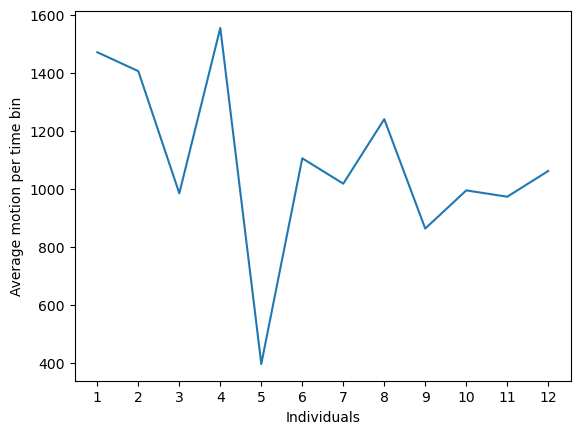

In [10]:
# show overall motion for individuals over experiment ... any outliers? dead?
print(individuals)
plt.plot(df[individuals].mean())
plt.xlabel('Individuals')
plt.ylabel('Average motion per time bin')
plt.show()

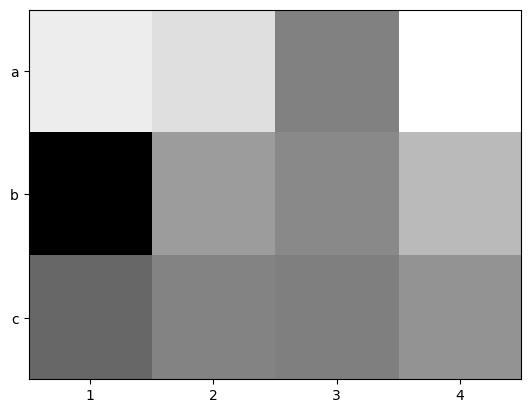

[[6518673.83390384 6229952.34248812 4364557.24918834 6890182.67536439]
 [1759115.15689909 4899093.54350239 4511712.16269633 5497156.89768392]
 [3826347.33967732 4409209.2666674  4312692.90275093 4705666.90323391]]


In [11]:
# another look at overall activity in plate ... are there any dead individuals that should be omitted?
# is the difference in illumination across the plate causing big problems?
totalActivity = df[individuals].sum().values
plateView = np.reshape(totalActivity,(3,4))
plt.imshow(plateView, interpolation='nearest', cmap = 'gray')
columns = np.array([1,2,3,4])
rows = ['a','b','c']
plt.xticks(columns-1, columns)
plt.yticks([0,1,2],rows) # or other way?
plt.show()

print(plateView)

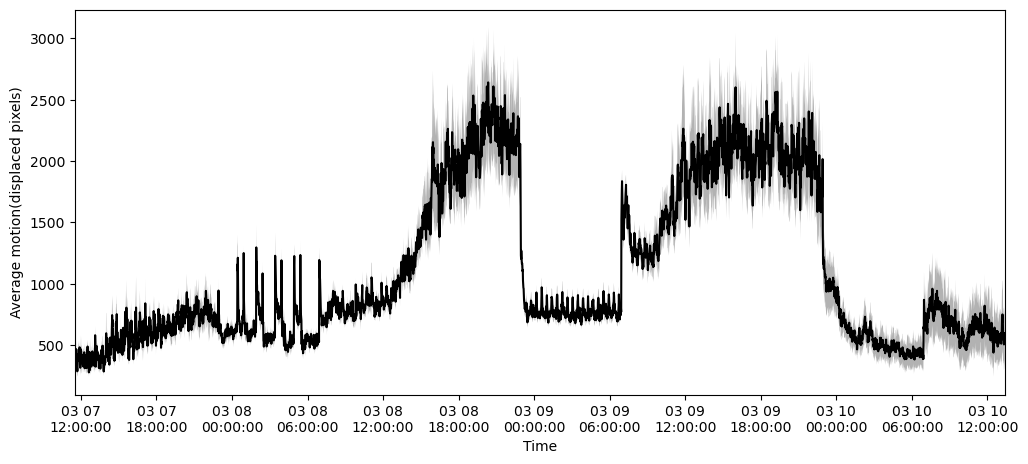

In [12]:
# ribbon plot of average motion
from matplotlib.ticker import MaxNLocator
def timeVdataRibbonPlot(ax,t,d,c, numticks=0): # axis, timeVec, data, color

    ax.plot(t,np.mean(d,axis=1),color=c)
    se = analysisTools.stde(d,1)
    ax.fill_between(t, np.mean(d,1)-se, np.mean(d,1)+se, alpha = 0.3, facecolor=c, edgecolor=None)
    ax.set_xlim([t[0],t[-1]])
    ax.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    if numticks > 0:
        ax.xaxis.set_major_locator(MaxNLocator(numticks)) 
    return ax

d = df[individuals].values
t = df['time'].values
f,a = plt.subplots(figsize=(12,5))

a = timeVdataRibbonPlot(a,t,d,'k',15)
a.set_xlabel('Time')
a.set_ylabel('Average motion(displaced pixels)')
plt.show()

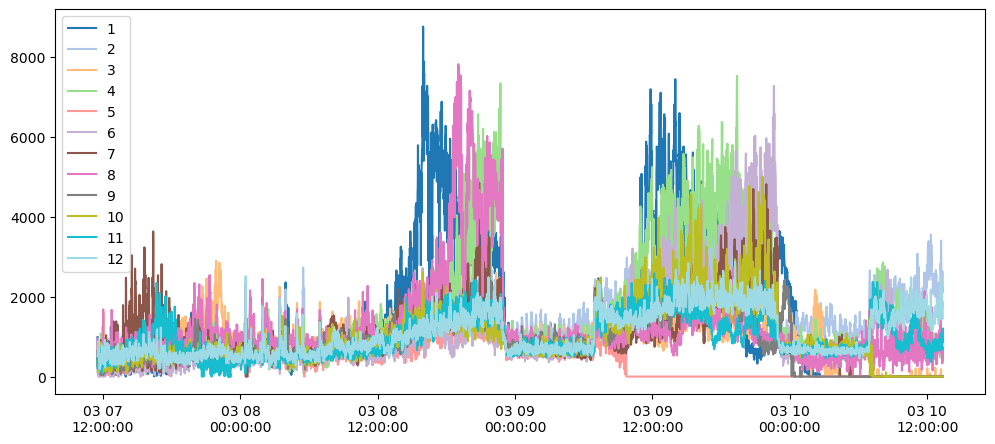

In [13]:
# plot activity of each individual in a different color
def multipleIndividualPlot(df, individuals):
    colormap = 'tab20'
    cols = analysisTools.make_N_colors(colormap, len(individuals))
    f,a = plt.subplots(figsize = (12,5))
    for i,individual in enumerate(individuals):
        plt.plot(df['time'].values, df[individual].values, color = cols[i] , label = individual)
    plt.legend()
    
    a.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    plt.show()
    
multipleIndividualPlot(df,individuals)

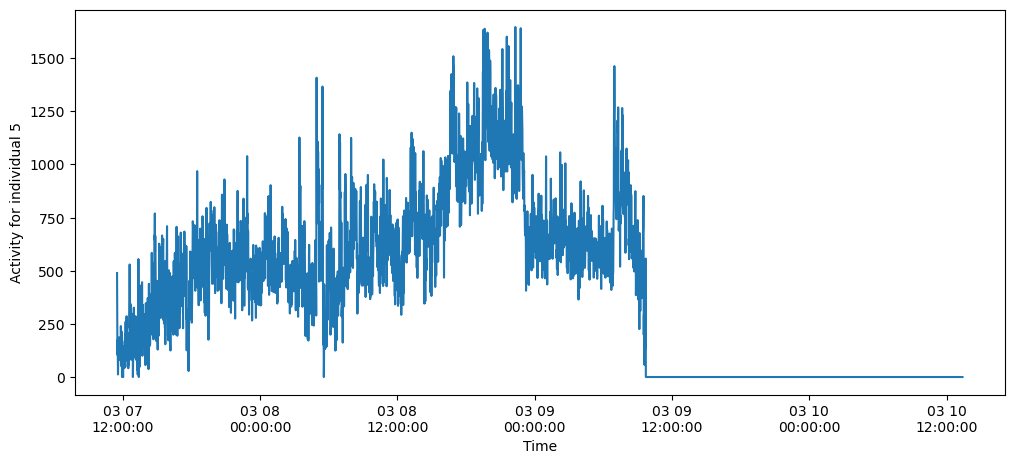

In [14]:
# plot a particular individual
individual_to_plot = 5

def oneIndividualPlot(individual=1):
    selection = str(individual)
    f,a = plt.subplots(figsize = (12,5))
    plt.plot(df['time'].values, df[selection].values)
    plt.ylabel('Activity for individual ' + selection)
    plt.xlabel('Time')
    a.xaxis.set_major_formatter( dates.DateFormatter('%m %d\n%H:%M:%S') )
    plt.show()
    
oneIndividualPlot(individual_to_plot)

# Select subset of data based on time

In [85]:
def timeslice(df, startdate, starttime, duration):
    # duration and buffer are in minutes
    
    startdatetime = startdate + ' ' + starttime
    
    delta = duration / (60*24)
    
    startdatenum = dates.datestr2num(startdatetime)
    startdatetime = dates.num2date(startdatenum)
    
    enddatenum = startdatenum + delta
    enddatetime = dates.num2date(enddatenum)
    
#     print('Start is ', startdatetime, ' which is ', str(startdatenum))
#     print('End is   ', enddatetime, ' which is ', str(enddatenum))
    timeselection = df[df['time'].between(startdatenum,enddatenum)]
    return timeselection

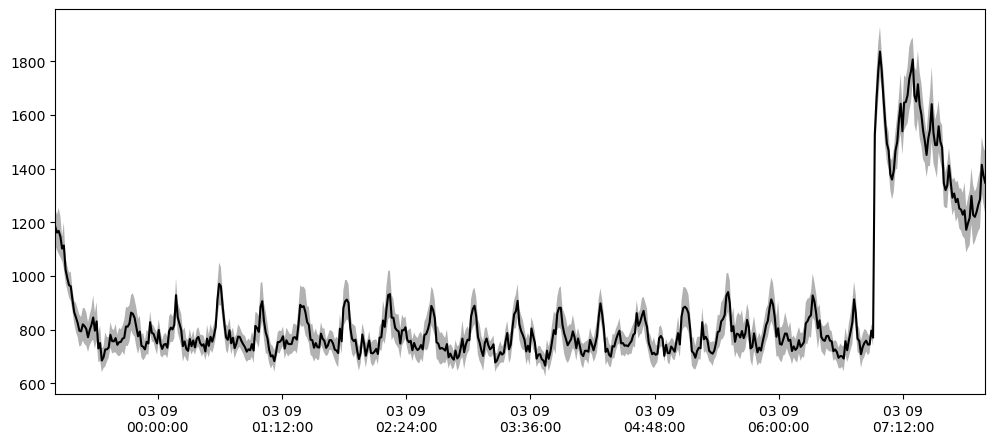

In [86]:
# for time of interest, enter date 'yyyy-mm-dd' and time 'hh:mm:ss'
# and enter desired time window (in minutes)

day = '2023-03-08'
time = '23:00:00'
duration = 540 # minutes ... 

ts = timeslice(df, day, time, duration)
d = ts[individuals].values
t = ts['time'].values
f,a = plt.subplots(figsize=(12,5))

a = timeVdataRibbonPlot(a,t,d,'k')#,15) # change number of ticks by including a number at end of arguments
plt.show()

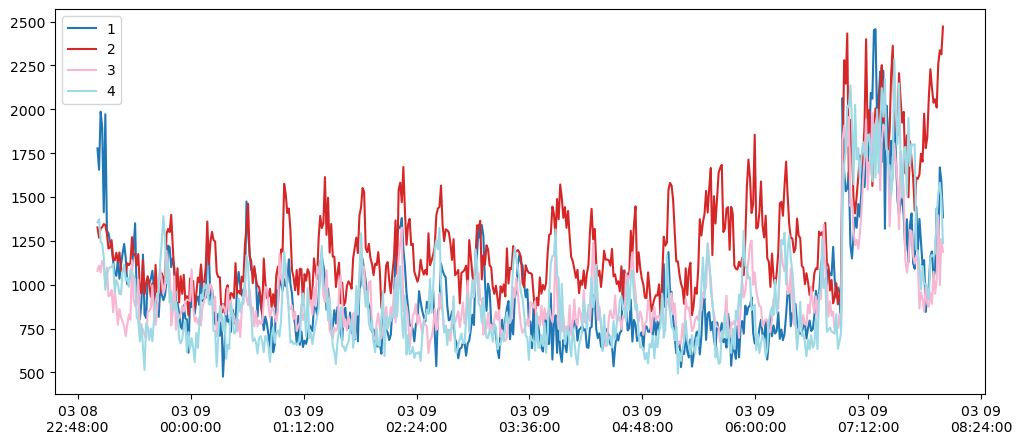

In [87]:
# can plot multiple individuals on the same plot, during time window of interest
multipleIndividualPlot(ts,['1','2','3','4'])

# Compare activity during two time windows

In [144]:
# A function to plot time vs activity to compare two time windows ... run this (will not have output here)
def plotTwoTimeWindows(ax, t, data, labels, colors, numticks=0): # axis, timeVec, data, color

    for i, d in enumerate(data):
        ax.plot(t, np.mean(d,axis=1),color=colors[i], label = labels[i])
        se = analysisTools.stde(d,1)
        ax.fill_between(t, np.mean(d,1)-se, np.mean(d,1)+se, alpha = 0.3, facecolor=colors[i], edgecolor=None)
    
    ax.set_xlim([t[0],t[-1]])
    ax.xaxis.set_major_formatter( dates.DateFormatter('%H:%M') )
    if numticks > 0:
        ax.xaxis.set_major_locator(MaxNLocator(numticks)) 
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Average motion (displaced pixels)')
    ax.legend()
    
    return ax

### Defining time periods of interest
For time of interest, enter date 'yyyy-mm-dd' and time 'hh:mm:ss' <br>
and enter desired time window (in minutes) to analyze <br>
need to run the cell above with the timeslice function, if not run already <br>

include your desired time window, plus a bit of time beforehand ... <br>
... if the data needs to be normalized to different levels of background activity <br>
for example, if I want to compare 60 minutes, I might choose 10 minutes of background <br>

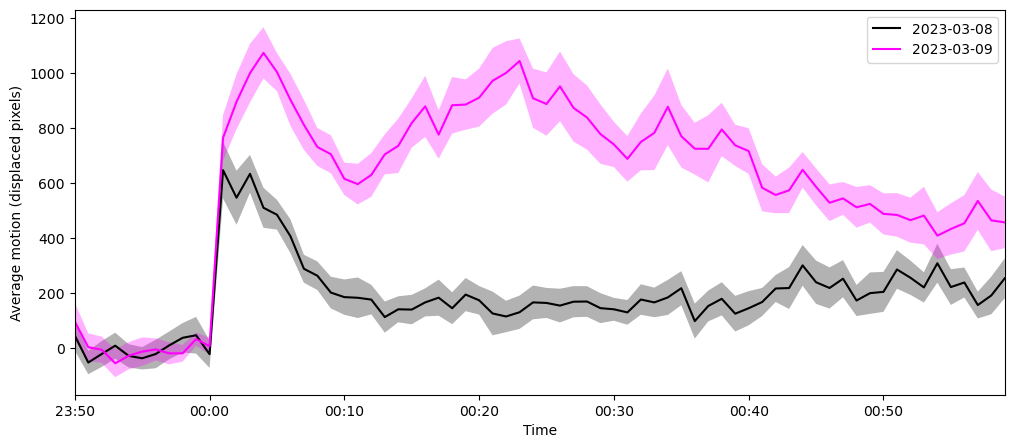

In [145]:
## set your time windows and colors here

duration = 60 # in minutes
buffer = 10 # background time before event ... set to zero if you do not want to normalize to background

day1 = '2023-03-08'
eventstart1 = '06:54:00'

day2 = '2023-03-09' # can be same day as day1
eventstart2 = '06:54:00'

# can choose colors here
day1color = 'black'
day2color = 'magenta'
# see https://matplotlib.org/stable/gallery/color/named_colors.html (scroll down) for usable colors



#### do not change this stuff below . . . 

# extract data from these time windows
ts1 = timeslice(df, day1, eventstart1, duration)
d1 = ts1[individuals].values
t1 = ts1['time'].values
starttime = t1[0]
timevec = t1

ts2 = timeslice(df, day2, eventstart2, duration)
d2 = ts2[individuals].values

# if buffer, extract that time
if buffer > 0:
    buffertime = buffer / (24*60)
    buffer1startnum = dates.datestr2num(day1 + ' ' + eventstart1) - buffertime
    buffer2startnum = dates.datestr2num(day2 + ' ' + eventstart2) - buffertime
    
    buffer1start = dates.num2date(buffer1startnum).strftime('%H:%M:%S')
    buffer2start = dates.num2date(buffer2startnum).strftime('%H:%M:%S')
    
    buffer1 = timeslice(df, day1, buffer1start, buffer)
    buffer2 = timeslice(df, day2, buffer2start, buffer)
    
    buffervals1 = buffer1[individuals].values
    buffervals2 = buffer2[individuals].values
    buffer1time = buffer1['time'].values
    
    background1 = np.mean(buffervals1)
    background2 = np.mean(buffervals2)
    
    normd1 = d1-background1
    normd2 = d2-background2
    
    d1 = np.vstack((buffervals1,d1))
    d2 = np.vstack((buffervals2,d2))
    
    d1 = d1-background1
    d2 = d2-background2
    
    timevec = np.concatenate((buffer1time, timevec))

else:
    normd1 = d1
    normd2 = d2
    
# define time vector
timevec = timevec - starttime
t = [dates.num2date(x) for x in timevec]

f,a = plt.subplots(figsize=(12,5))

a = plotTwoTimeWindows(a, t, [d1,d2], [day1,day2], [day1color,day2color]) 

plt.show()

Kruskal-Wallis p =  0.00034415785384658837
t-test p =  1.0877854132918276e-05


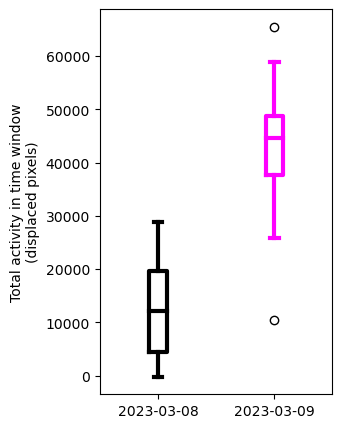

In [143]:
# boxplot to compare activity in time window
# can set plot size window here

plotwidth = 3
plotheight = 5

### do not change stuff below

# format colors of a boxplot object
def formatBoxColors(bp, plotColors):
    boxColors = plotColors
    baseWidth = 3
    alpha = 1
    for n,box in enumerate(bp['boxes']):
        box.set( color=boxColors[n], linewidth=baseWidth)

    for n,med in enumerate(bp['medians']):
        med.set( color=boxColors[n], linewidth=baseWidth)

    bdupes=[]
    for i in boxColors:
        bdupes.extend([i,i])

    boxColors = bdupes
    for n,whisk in enumerate(bp['whiskers']):
        whisk.set( color=boxColors[n], linewidth=baseWidth, alpha = alpha)

    for n,cap in enumerate(bp['caps']):
        cap.set( color=boxColors[n], linewidth=baseWidth, alpha = alpha)

    return bp

activity1 = np.sum(normd1,axis=0)
activity2 = np.sum(normd2,axis=0)
f,a = plt.subplots(1, figsize=(plotwidth,plotheight))
bp = a.boxplot([activity1,activity2])
bp = formatBoxColors(bp, [day1color,day2color])
a.set_ylabel('Total activity in time window\n(displaced pixels)')
a.set_xticks([1,2], [day1,day2])
_,p = stats.kruskal(activity1,activity2)
print('Kruskal-Wallis p = ',p)
_,p = stats.ttest_ind(activity1,activity2)
print('t-test p = ',p)
plt.show()